In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.calibration import CalibrationDisplay

In [2]:
# ----------------------------------------------------------------------
# 0. LOAD CLEANED DATA
# ----------------------------------------------------------------------

DATA_PATH = "data/default_cc_clean_stage1.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.head())

print("\nColumns:")
print(df.columns.tolist())

possible_targets = ["default.payment.next.month", "default payment next month"]
TARGET_COL = None
for col in possible_targets:
    if col in df.columns:
        TARGET_COL = col
        break

if TARGET_COL is None:
    raise ValueError("Target column not found. Check the column name in your CSV.")

print("\nUsing target column:", TARGET_COL)

Shape: (30000, 24)
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE   AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0    20000.0    2          2         1  24.0      2      2     -1     -1   
1   120000.0    2          2         2  26.0     -1      2      0      0   
2    90000.0    2          2         2  34.0      0      0      0      0   
3    50000.0    2          2         1  37.0      0      0      0      0   
4    50000.0    1          2         1  57.0     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1      0  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2      0  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3      0  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4      0  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default pa

In [3]:
# ----------------------------------------------------------------------
# 1. DEFINE  (X) AND (y)
# ----------------------------------------------------------------------

cat_cols = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]

#
num_cols = [c for c in df.columns if c not in cat_cols + [TARGET_COL]]

print("\nCategorical columns:", cat_cols)
print("Numeric columns:", num_cols)

X = df[cat_cols + num_cols]
y = df[TARGET_COL]

print("\nTarget distribution:")
print(y.value_counts(normalize=True))


Categorical columns: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Numeric columns: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

Target distribution:
default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


In [4]:
# ----------------------------------------------------------------------
# 2. T/T SPLIT 
# ----------------------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,      
    random_state=42,
    stratify=y,         
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (21000, 23)
Test shape: (9000, 23)


In [5]:
# ----------------------------------------------------------------------
# 3. PIPELINE
# ----------------------------------------------------------------------

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [6]:
# ----------------------------------------------------------------------
# 4. LOGISTIC REGRESSION
# ----------------------------------------------------------------------

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  
    solver="lbfgs",
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg),
    ]
)

print("\nFitting Logistic Regression...")
log_reg_pipeline.fit(X_train, y_train)

# Predicted labels
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)


Fitting Logistic Regression...



[Logistic] ROC AUC: 0.7635
[Logistic] KS statistic: 0.4029

[Logistic] Confusion matrix (threshold=0.5):
[[5858 1151]
 [ 868 1123]]


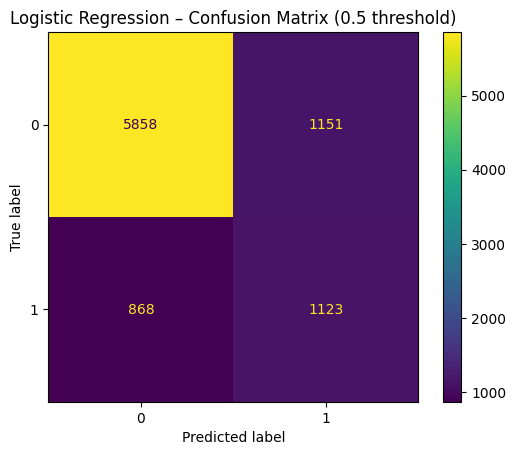


[Logistic] Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7009
           1       0.49      0.56      0.53      1991

    accuracy                           0.78      9000
   macro avg       0.68      0.70      0.69      9000
weighted avg       0.79      0.78      0.78      9000



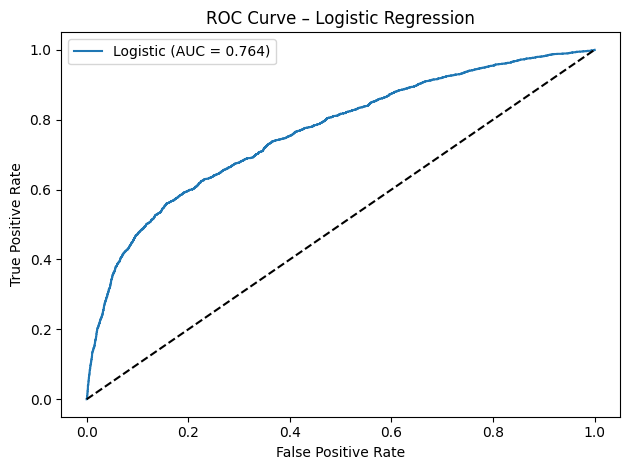

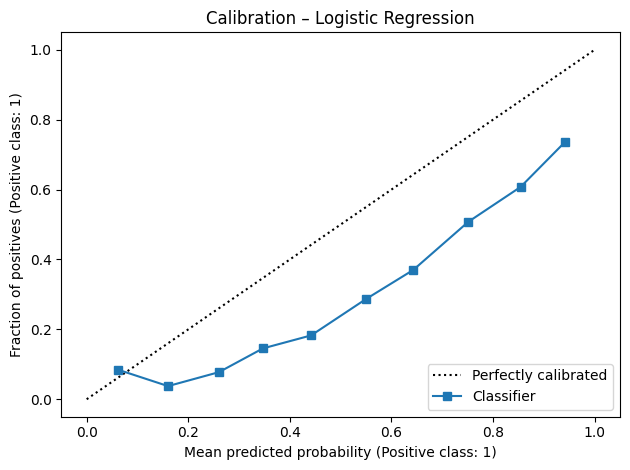

In [7]:
# ----------------------------------------------------------------------
# 4.1 LOGISTIC –: AUC, KS, CONFUSION MATRIX, REPORT, CALIBRATION
# ----------------------------------------------------------------------

# AUC
auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f"\n[Logistic] ROC AUC: {auc_lr:.4f}")

# KS statistic = max(TPR - FPR)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_lr)
ks_lr = np.max(tpr_lr - fpr_lr)
print(f"[Logistic] KS statistic: {ks_lr:.4f}")

# Confusion matrix at 0.5 threshold
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\n[Logistic] Confusion matrix (threshold=0.5):")
print(cm_lr)

ConfusionMatrixDisplay(cm_lr).plot()
plt.title("Logistic Regression – Confusion Matrix (0.5 threshold)")
plt.show()

# Classification
print("\n[Logistic] Classification report (threshold=0.5):")
print(classification_report(y_test, y_pred_lr))

# ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC = {auc_lr:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration plot
CalibrationDisplay.from_predictions(y_test, y_proba_lr, n_bins=10)
plt.title("Calibration – Logistic Regression")
plt.tight_layout()
plt.show()

In [8]:
# ----------------------------------------------------------------------
# 5. TREE-BASED
# ----------------------------------------------------------------------

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),  # still use ONE for cat
        ("model", rf_clf),
    ]
)

print("\nFitting Random Forest...")
rf_pipeline.fit(X_train, y_train)


y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)


Fitting Random Forest...



[Random Forest] ROC AUC: 0.7743
[Random Forest] KS statistic: 0.4233

[Random Forest] Confusion matrix (threshold=0.5):
[[6388  621]
 [1085  906]]


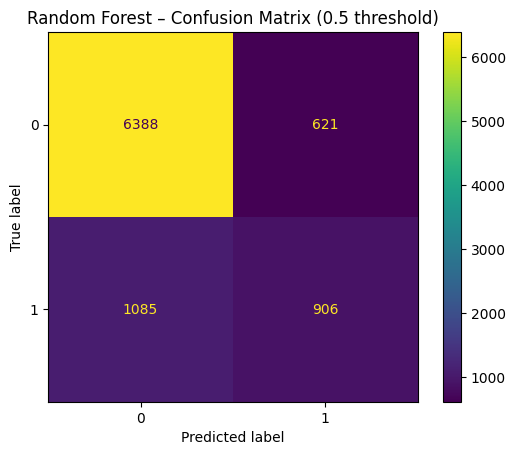


[Random Forest] Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      7009
           1       0.59      0.46      0.52      1991

    accuracy                           0.81      9000
   macro avg       0.72      0.68      0.70      9000
weighted avg       0.80      0.81      0.80      9000



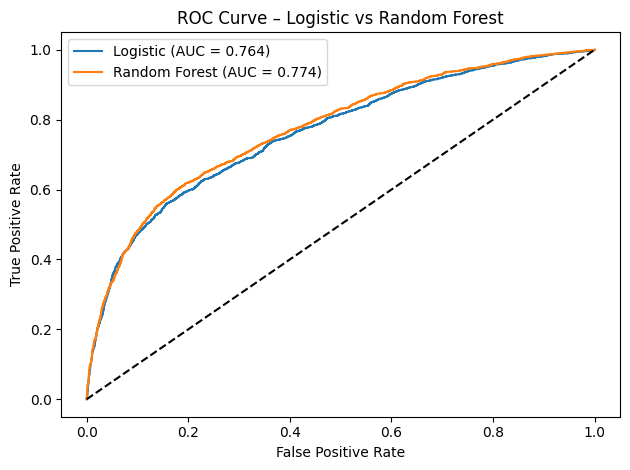

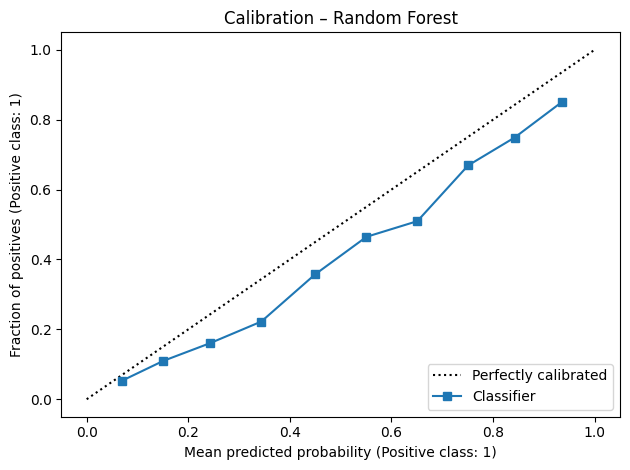

In [9]:
# ----------------------------------------------------------------------
# 5.1 RANDOM FOREST
# ----------------------------------------------------------------------

# AUC
auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\n[Random Forest] ROC AUC: {auc_rf:.4f}")

# KS
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
ks_rf = np.max(tpr_rf - fpr_rf)
print(f"[Random Forest] KS statistic: {ks_rf:.4f}")

# Confusion matrix at 0.5 threshold
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\n[Random Forest] Confusion matrix (threshold=0.5):")
print(cm_rf)

ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Random Forest – Confusion Matrix (0.5 threshold)")
plt.show()

# Classification report
print("\n[Random Forest] Classification report (threshold=0.5):")
print(classification_report(y_test, y_pred_rf))

# ROC curves comparison
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic vs Random Forest")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration plot
CalibrationDisplay.from_predictions(y_test, y_proba_rf, n_bins=10)
plt.title("Calibration – Random Forest")
plt.tight_layout()
plt.show()
